In [1]:
# Nikhil Patil
# CSEC 620 Project 2
# K-Means Clustering Implementation 
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from scipy.optimize import linear_sum_assignment

# K Means Code was taken and modified from here: https://github.com/aihubprojects/Machine-Learning-From-Scratch/blob/master/K-Means%20from%20Scratch.ipynb 
#  I followed this tutorial as well to help understand how to prepare and use the data: https://www.geeksforgeeks.org/kmeans-clustering-and-pca-on-wine-dataset/

WINE_DATA = pd.read_csv("./wine/wine.data")
IRIS_DATA = pd.read_csv("./Iris/iris.data")


# K-means clustering algorithm
class KMeans:
    """
    A simple K-means clustering implementation.

    This class implements the K-means clustering algorithm to group data points into `k` clusters
    based on their distance to the cluster centroids. The centroids are initialized randomly, and
    the algorithm iterates to minimize the within-cluster variance.

    Attributes:
        k (int): The number of clusters to form.
        max_iters (int): The maximum number of iterations for the algorithm to converge. Default is 100.
        centroids (np.ndarray): The coordinates of the cluster centroids.
        clusters (np.ndarray): The cluster labels for each data point.
    
    Methods:
        euclidean_distance(point1, point2): Computes the Euclidean distance between two data points.
        fit(X): Fits the K-means model to the data by determining the cluster centroids and assigning data points to clusters.
        predict(X): Predicts the nearest cluster for a new set of data points based on the fitted centroids.
        create_clusters(X): Assigns data points to the nearest cluster based on the current centroids.
        calculate_centroids(X): Calculates the new centroids based on the data points in each cluster.
    """

    def __init__(self, k=3, max_iters=100):
        self.k = k
        self.max_iters = max_iters
        self.centroids = None
        self.clusters = None

    def euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def fit(self, X):

        np.random.seed(random.randint(1, 100))  # for reproducibility
        random_indices = np.random.permutation(X.shape[0])[:self.k]
        self.centroids = X[random_indices]

        for i in range(self.max_iters):
            self.clusters = self.create_clusters(X)
            old_centroids = self.centroids
            self.centroids = self.calculate_centroids(X)
            if np.all(old_centroids == self.centroids):
                break

    def create_clusters(self, X):
        clusters = [[] for _ in range(self.k)]
        for idx, point in enumerate(X):
            closest_centroid = np.argmin([self.euclidean_distance(point, centroid) for centroid in self.centroids])
            clusters[closest_centroid].append(idx)
        return clusters

    def calculate_centroids(self, X):
        centroids = np.zeros((self.k, X.shape[1]))
        for cluster_idx, cluster in enumerate(self.clusters):
            if cluster:  # Avoid empty clusters
                centroids[cluster_idx] = np.mean(X[cluster], axis=0)
        return centroids

    def predict(self, X):
        return np.array([np.argmin([self.euclidean_distance(x, centroid) for centroid in self.centroids]) for x in X])

In [2]:
def get_column_names():
    """
    Obtains column names for the respective datasets as the datasets come unlabeled
    
    It takes the filepath from the directory, creates a list for the columns as well as line counter. 
    Line counter counts the lines in the file until it reaches a certain threshold, where it then adds those lines to the list of columns. The lines will not change unless the .names files are modifiied.
    After adding the column names to a list, regular expressions are used to clean up the strings (remove numbers). 
    
    :return: two python lists consisting of columns
    """
    wine_names = "./wine/wine.names"
    iris_names = "./Iris/iris.names"
    wine_columns = []
    iris_columns = []

    wine_line_counter = 0
    iris_line_counter = 0
    class_identifier = ""
    with open(wine_names) as f:
        for line in f:
            wine_line_counter += 1
            if (wine_line_counter > 57 and wine_line_counter <= 70):
                line = line.strip()
                wine_columns.append(line)
            if wine_line_counter == 75:
                line = line.strip()
                class_identifier = re.search(r'\bclass\b', line)
    f.close()
    wine_columns = [re.sub(r'^\d+\)\s*', '', column) for column in wine_columns]
    wine_columns.insert(0, class_identifier.group())
    with open(iris_names) as f:
        for line in f:
            iris_line_counter += 1
            if (iris_line_counter > 50 and iris_line_counter < 56):
                line = line.strip()
                iris_columns.append(line)
    f.close()
    iris_columns = [re.sub(r'^\d+\.\s*', '', column) for column in iris_columns]

    print(wine_columns)
    print(iris_columns)

    return wine_columns, iris_columns

In [3]:
def wine_classification(wine_columns):
    """
    This function aims to classify different types of Wines via a dataset and using K-means clustering. It also processes the dataframe prior to use and uses seaborn to plot the dataset as well as to create a heatmap.     
    :param wine_columns: The column headers of the Wine dataset
    """
    df = WINE_DATA
    df.columns = wine_columns
    
    class_mapping = {1: 'Wine 1', 2: 'Wine 2', 3: 'Wine 3'}

    # Replace the class labels with the corresponding strings
    df['class'] = df['class'].replace(class_mapping)
    actual_labels = df['class'].values
    label_mapping = {'Wine 1': 0, 'Wine 2': 1, 'Wine 3': 2}
    actual_labels = [label_mapping[label] for label in actual_labels]
    df.drop("class", axis=1, inplace=True)
#
    scaler = StandardScaler()
    transformed_features = scaler.fit_transform(df)
    
    scaled_df = pd.DataFrame(transformed_features, columns=df.columns)
    
    # Apply KMeans clustering
    kmeans = KMeans(k=3)  # Three clusters since 3 types of wine
    kmeans.fit(scaled_df.values)  # Fit the model on the scaled features
    
    # Get the predicted cluster labels
    clusters = kmeans.predict(scaled_df.values)
    scaled_df['Cluster'] = clusters  # Add cluster labels to the DataFrame for analysis
    
    # Perform PCA for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_df.drop('Cluster', axis=1))
    
    pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
    pca_df['Cluster'] = clusters  # Add clusters to the PCA result
    
    # Plot the PCA results
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.8)
    plt.title('Wine Clusters Visualized using PCA')
    plt.show()

    # Plot PCA components as a heatmap
    component_df = pd.DataFrame(pca.components_, index=['PCA1', "PCA2"], columns=df.columns)
    sns.heatmap(component_df)
    plt.show()
    
    # Create a cluster-to-class mapping using linear_sum_assignment to map clusters to actual labels
    conf_matrix = confusion_matrix(actual_labels, clusters)
    
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)
    cluster_to_class_mapping = {row: col for row, col in zip(row_ind, col_ind)}
    
    # Map clusters to predicted class labels
    predicted_labels = [cluster_to_class_mapping[cluster] for cluster in clusters]
    
    # Generate and print the classification report
    target_names = ["Wine 1", "Wine 2", "Wine 3"]
    print(classification_report(actual_labels, predicted_labels, target_names=target_names, zero_division=1))    
    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
                xticklabels=["Cluster 0", 'Cluster 1', "Cluster 2"], yticklabels=target_names)
    
    plt.xlabel("Predicted Clusters")
    plt.ylabel("Actual Classes")
    plt.title("Confusion Matrix for K-means Clustering on Wine Dataset")
    plt.show()

In [4]:
def iris_classification(iris_columns):
    """
    This function aims to classify different types of Iris' flowers via a dataset and using K-means clustering. It also processes the dataframe prior to use and uses seaborn to plot the dataset as well as to create a heatmap. 
    :param iris_columns: a list of column headers
    """
    df = IRIS_DATA
    df.columns = iris_columns
    actual_labels = df['class:'].values
    label_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
    actual_labels = [label_mapping[label] for label in actual_labels]
    df.drop("class:", axis=1, inplace=True)
    # df.info()

    scaler = StandardScaler()
    transformed_features = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(transformed_features, columns=df.columns)
    # print(scaled_df.head(2))

    kmeans = KMeans(k=3)  # three clusters since 3 different types of wine 
    kmeans.fit(scaled_df.values)  # Fit the model on the scaled features

    clusters = kmeans.predict(scaled_df.values)
    scaled_df['Cluster'] = clusters

    # Perform PCA to reduce to 2 components for visualization
    pca = PCA(n_components=2)

    # Apply PCA only on the numerical features (exclude 'Cluster' column)
    pca_result = pca.fit_transform(scaled_df.drop('Cluster', axis=1))

    # Create a new DataFrame for the PCA results and the cluster labels
    pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
    pca_df['Cluster'] = clusters

    # Plot the PCA results with clusters
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.8)
    plt.title('Different Types of Iris Flowers Visualized using PCA')
    plt.show()

    component_df = pd.DataFrame(pca.components_, index=['PCA1', "PCA2"], columns=df.columns)
    # Heat map
    sns.heatmap(component_df)
    plt.show()

    # Create confusion matrix and classification report 
    conf_matrix = confusion_matrix(actual_labels, clusters)

    row_ind, col_ind = linear_sum_assignment(-conf_matrix)

    # Create a mapping from cluster to true class
    cluster_to_class_mapping = {row: col for row, col in zip(row_ind, col_ind)}
    predicted_labels = [cluster_to_class_mapping[cluster] for cluster in clusters]

    print(classification_report(actual_labels, predicted_labels,
                                target_names=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']))

    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
                xticklabels=['Cluster 0', 'Cluster 1', 'Cluster 2'],
                yticklabels=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])

    plt.xlabel("Predicted Clusters")
    plt.ylabel("Actual Classes")
    plt.title("Confusion Matrix for K-means Clustering on Iris Dataset")
    plt.show()

['class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
['sepal length in cm', 'sepal width in cm', 'petal length in cm', 'petal width in cm', 'class:']


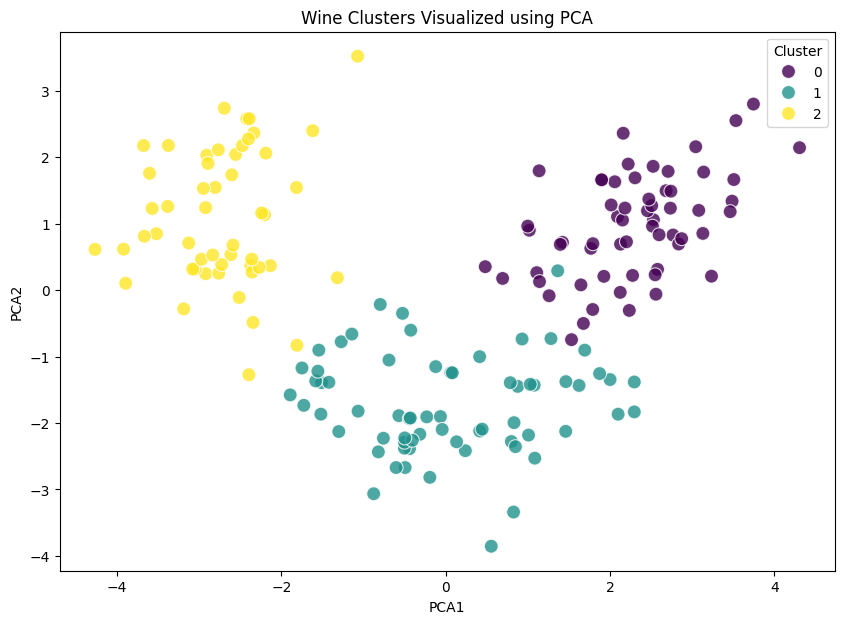

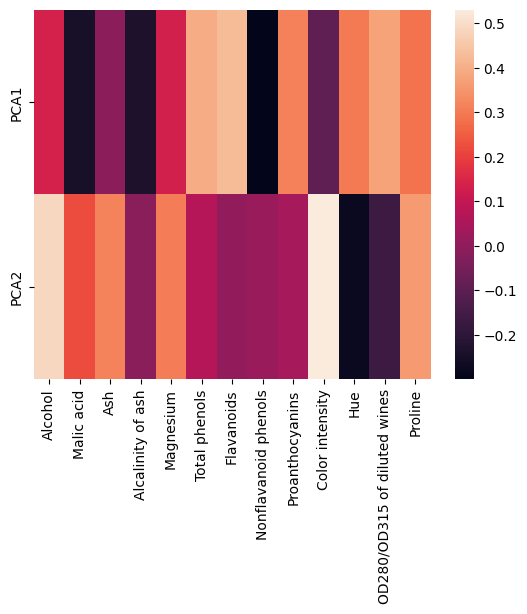

              precision    recall  f1-score   support

      Wine 1       0.97      1.00      0.98        58
      Wine 2       1.00      0.93      0.96        71
      Wine 3       0.94      1.00      0.97        48

    accuracy                           0.97       177
   macro avg       0.97      0.98      0.97       177
weighted avg       0.97      0.97      0.97       177



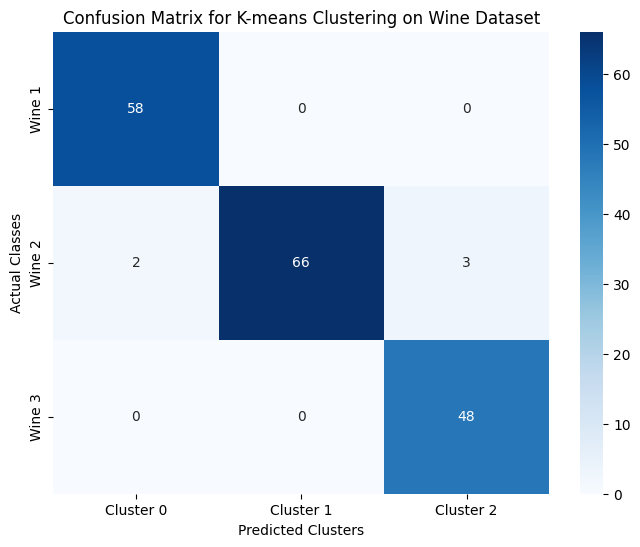

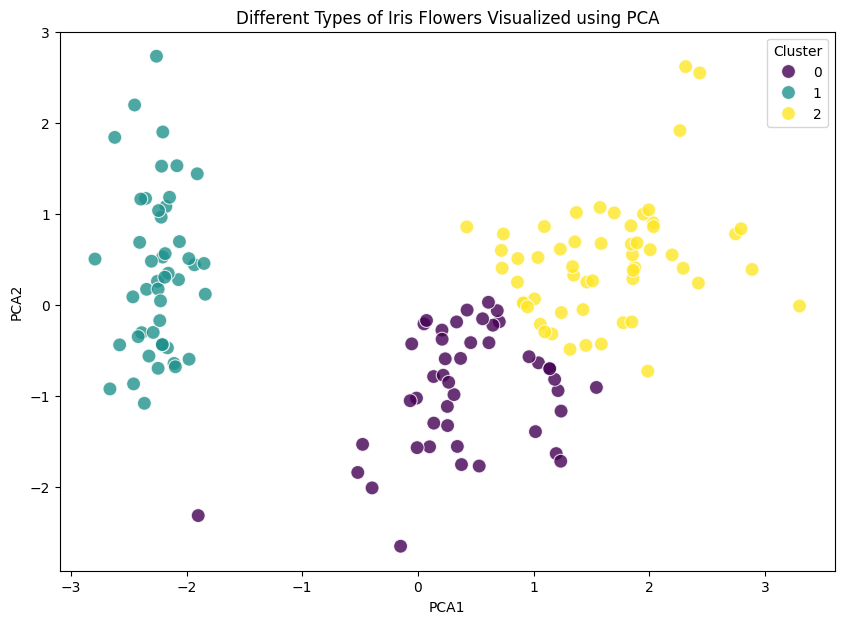

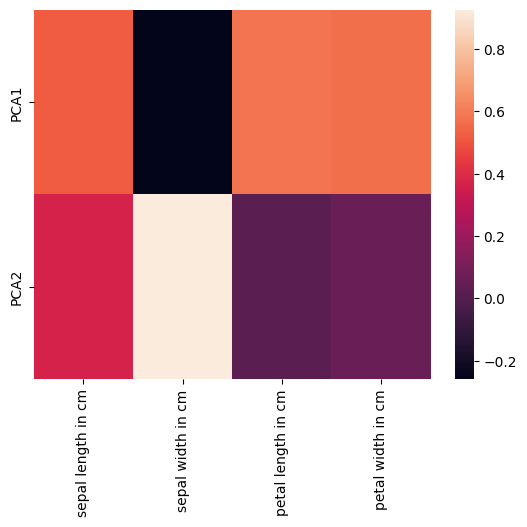

                 precision    recall  f1-score   support

    Iris-setosa       1.00      0.98      0.99        49
Iris-versicolor       0.80      0.74      0.77        50
 Iris-virginica       0.76      0.84      0.80        50

       accuracy                           0.85       149
      macro avg       0.86      0.85      0.85       149
   weighted avg       0.86      0.85      0.85       149



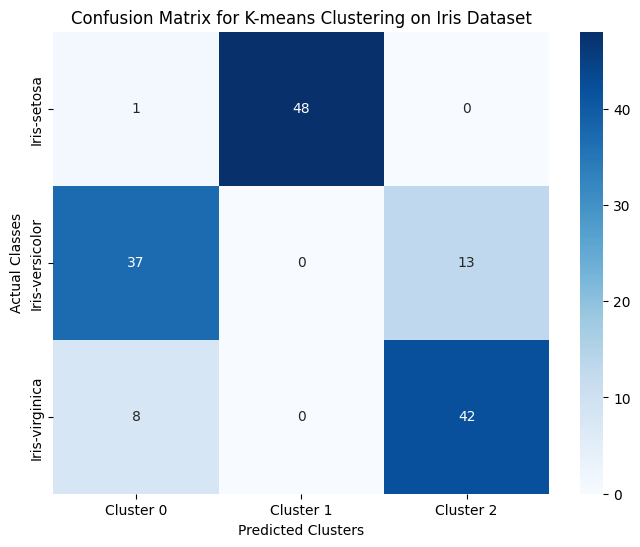

In [5]:
def main():
    wine_columns, iris_columns = get_column_names()
    wine_classification(wine_columns)
    iris_classification(iris_columns)


if __name__ == "__main__":
    main()